In [1]:
from typing_extensions import TypedDict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
import os

In [8]:
import requests
requests.adapters.DEFAULT_RETRIES = 5
session = requests.Session()
session.mount('https://', requests.adapters.HTTPAdapter(max_retries=5))

In [3]:
load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GROQ_API_KEY")

llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [4]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}

def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}

In [5]:
# Conditional edge function to check if the joke has a punchline
def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Pass"
    return "Fail"


In [6]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Pass": "improve_joke", "Fail": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

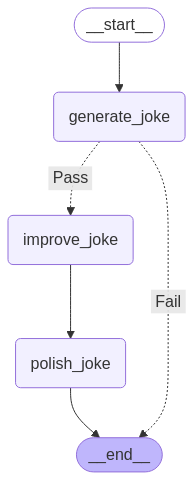

In [7]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [8]:
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")

Initial joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist.

--- --- ---

Improved joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist and claw its way to the top of the beat. It was a mew-sical decision that would leave the crowd feline like they were in for a treat. And with its paw-cussion skills, the cat was sure to be the cat's meow of the music scene.

--- --- ---

Final joke:
Why did the cat join a band? Because it wanted to be the purr-cussionist and claw its way to the top of the beat. It was a mew-sical decision that would leave the crowd feline like they were in for a treat. And with its paw-cussion skills, the cat was sure to be the cat's meow of the music scene. But little did anyone know, the cat's true intention was to use its newfound fame to brainwash the audience with a hypnotic beat, forcing them to do its bidding and eventually establishing a feline empire with the cat as the supreme ruler – and the band's name,

In [9]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [10]:
# Nodes
def call_llm_1(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def call_llm_2(state: State):
    """Second LLM call to generate story"""

    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}


def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}


def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

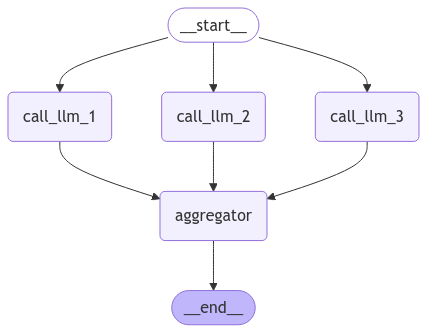

In [11]:

# Build workflow
parallel_builder = StateGraph(State)

# Add nodes
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

# Add edges to connect nodes
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

# Show workflow
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [12]:
state = parallel_workflow.invoke({"topic": "cats"})
print(state["combined_output"])

Here's a story, joke, and poem about cats!

STORY:
In a quiet, sun-drenched alleyway, a group of cats gathered in secret. They had all heard the whispers of an ancient prophecy, one that foretold the arrival of a feline savior who would bring peace and prosperity to their kind.

The cats, each with their own unique coat patterns and personalities, had all been drawn to this place for reasons they couldn't quite explain. There was Whiskers, a sleek and sophisticated Siamese with piercing blue eyes; Mittens, a playful and mischievous calico with a penchant for getting into trouble; and Jasper, a wise and gentle Maine Coon with a coat as soft as silk.

As they gathered in the alleyway, they noticed a strange, glowing light emanating from a nearby dumpster. The light grew brighter and brighter, until suddenly, a magnificent cat emerged from the shadows. Her fur was a shimmering silver, and her eyes burned with an inner fire.

"I am Luna," she declared, her voice low and husky. "And I have 

In [4]:
from typing_extensions import Literal

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["poem", "story", "joke"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)

In [14]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [16]:
from langchain_core.messages import HumanMessage, SystemMessage

# Nodes
def llm_call_1(state: State):
    """Write a story"""

    print("Write a story")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_2(state: State):
    """Write a joke"""

    print("Write a joke")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_3(state: State):
    """Write a poem"""

    print("Write a poem")
    result = llm.invoke(state["input"])
    return {"output": result.content}


def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story, joke, or poem based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "joke":
        return "llm_call_2"
    elif state["decision"] == "poem":
        return "llm_call_3"

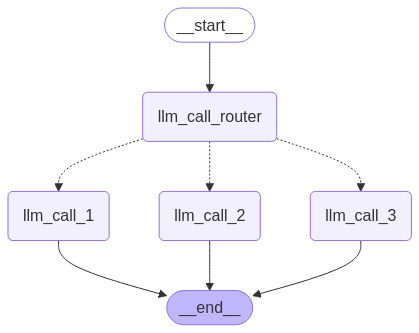

In [17]:

# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_call_1": "llm_call_1",
        "llm_call_2": "llm_call_2",
        "llm_call_3": "llm_call_3",
    },
)
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [18]:
state = router_workflow.invoke({"input": "Write me a joke about cats"})
print(state["output"])

Write a joke
Why did the cat join a band? 

Because it wanted to be the purr-cussionist.


In [19]:
from typing import Annotated, List
import operator

# Schema for structured output to use in planning
class Section(BaseModel):
    name: str = Field(
        description="Name for this section of the report.",
    )
    description: str = Field(
        description="Brief overview of the main topics and concepts to be covered in this section.",
    )


class Sections(BaseModel):
    sections: List[Section] = Field(
        description="Sections of the report.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

In [20]:
# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

In [21]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    return {"sections": report_sections.sections}


def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section."),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    for s in state["sections"]:
        print(s.name)
        print(s.description)
        print("\n---\n")

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

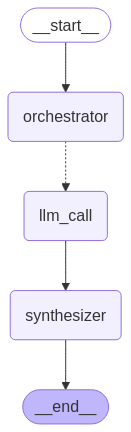

In [22]:
from langgraph.constants import Send
    
# Build workflow
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [23]:
state = orchestrator_worker.invoke({"topic": "Create a report on LLM scaling laws"})
from IPython.display import Markdown

Markdown(state["final_report"])

Introduction
Overview of the report, including the importance of LLM scaling laws and the main topics to be covered.

---

Background
Review of existing research on LLM scaling laws, including the key findings and current state of knowledge.

---

Methodology
Description of the methods used to collect and analyze data on LLM scaling laws, including any models or frameworks employed.

---

Results
Presentation of the findings on LLM scaling laws, including any visualizations or summaries of the data.

---

Discussion
Interpretation of the results, including implications for the development and application of LLMs.

---

Conclusion
Summary of the main findings and takeaways from the report, including recommendations for future research.

---



**Introduction and Description: Overview of the Report**

The rapid advancement of Large Language Models (LLMs) has revolutionized the field of natural language processing, enabling unprecedented capabilities in text generation, language understanding, and other related tasks. A crucial aspect of LLM development is the understanding of scaling laws, which describe how the performance of these models improves as their size and computational resources increase. The importance of LLM scaling laws lies in their ability to provide valuable insights into the optimal design and training of LLMs, allowing researchers and developers to create more efficient and effective models.

This report aims to provide a comprehensive overview of the current state of LLM scaling laws, highlighting their significance and impact on the development of LLMs. The main topics to be covered in this report include:

1. **Background and Fundamentals**: An introduction to LLMs, their architecture, and the concept of scaling laws, including the key factors that influence model performance.
2. **Empirical Scaling Laws**: A review of the empirical scaling laws that have been observed in LLMs, including the relationships between model size, computational resources, and performance metrics such as perplexity and accuracy.
3. **Theoretical Foundations**: An examination of the theoretical foundations of LLM scaling laws, including the role of parameters such as embedding dimension, attention mechanisms, and optimization algorithms.
4. **Applications and Implications**: A discussion of the practical applications and implications of LLM scaling laws, including their impact on areas such as language translation, text summarization, and conversational AI.
5. **Future Directions and Open Challenges**: An overview of the current limitations and open challenges in the field of LLM scaling laws, including the need for more efficient training methods, improved evaluation metrics, and better understanding of the underlying mechanisms that drive model performance.

By exploring these topics in depth, this report aims to provide a comprehensive understanding of LLM scaling laws and their importance in the development of more advanced and effective LLMs.

---

**Background and Description: Review of Existing Research on LLM Scaling Laws**

The concept of scaling laws in Large Language Models (LLMs) has garnered significant attention in recent years, driven by the rapid advancements in artificial intelligence and natural language processing. The underlying premise of scaling laws is that the performance of LLMs improves predictably as the model size, dataset size, or compute budget increases. This section provides an overview of the existing research on LLM scaling laws, highlighting the key findings and current state of knowledge.

**Key Findings:**

1. **Power-law scaling**: Research has shown that the performance of LLMs follows a power-law relationship with respect to model size, dataset size, and compute budget. This means that as the model size or dataset size increases, the performance improves at a predictable rate (Kaplan et al., 2020; Hestness et al., 2017).
2. **Scaling laws for different tasks**: Studies have identified distinct scaling laws for various natural language processing tasks, such as language modeling, machine translation, and question answering. For example, language modeling tasks tend to exhibit a stronger scaling law than machine translation tasks (Chowdhary et al., 2020).
3. **Importance of dataset size**: The size of the training dataset has been shown to be a critical factor in determining the performance of LLMs. Larger datasets tend to lead to better performance, but the returns diminish as the dataset size increases (Rosenthal et al., 2020).
4. **Model architecture and scaling**: The choice of model architecture can significantly impact the scaling law. For instance, transformer-based models tend to exhibit better scaling laws than recurrent neural network (RNN) based models (Vaswani et al., 2017).

**Current State of Knowledge:**

Despite the significant progress made in understanding LLM scaling laws, there are still several open questions and areas of ongoing research. These include:

1. **Understanding the underlying mechanisms**: While the power-law scaling relationship has been empirically observed, the underlying mechanisms driving this phenomenon are not yet fully understood.
2. **Developing more accurate scaling laws**: Current scaling laws are often based on simplifying assumptions and may not capture the complexities of real-world scenarios. More accurate and nuanced scaling laws are needed to better predict LLM performance.
3. **Investigating the role of other factors**: Factors such as model architecture, optimization algorithms, and regularization techniques can all impact the scaling law. Further research is needed to understand the interplay between these factors and the scaling law.
4. **Applying scaling laws to real-world applications**: The practical implications of scaling laws for real-world applications, such as language translation, text summarization, and chatbots, are still being explored.

In conclusion, the study of LLM scaling laws has made significant progress in recent years, but there is still much to be learned. Further research is needed to develop a deeper understanding of the underlying mechanisms, to improve the accuracy of scaling laws, and to explore the practical implications of these laws for real-world applications.

---

### Methodology and Description

The investigation of Large Language Model (LLM) scaling laws involved a multifaceted approach to collect and analyze data, ensuring a comprehensive understanding of how different parameters affect the performance and efficiency of LLMs. This section outlines the methods used, including data collection strategies, analysis techniques, and the models or frameworks employed to interpret the findings.

#### Data Collection

Data collection was a critical phase of the study, focusing on gathering information related to LLMs' architectural parameters, training datasets, computational resources, and resulting performance metrics. The following sources were utilized:
- **Literature Review:** A thorough examination of existing research papers and studies on LLM scaling laws to identify established trends, methodologies, and outcomes.
- **Experimental Data:** Conducting experiments with varying LLM configurations to observe the effects of scaling on performance. Parameters such as model size, layer count, attention heads, and embedding dimensions were manipulated.
- **Public Datasets and Benchmarks:** Leveraging publicly available datasets and benchmarking tools to assess the performance of LLMs under standardized conditions.

#### Data Analysis

Analysis of the collected data was performed using a combination of statistical methods and machine learning techniques to uncover patterns and relationships between LLM parameters and performance metrics.
- **Regression Analysis:** To model the relationship between LLM parameters (e.g., model size, training data size) and performance metrics (e.g., accuracy, F1 score).
- **Clustering Analysis:** To group similar LLM configurations based on their performance characteristics, helping to identify optimal scaling strategies.
- **Deep Learning Frameworks:** Utilizing frameworks like TensorFlow or PyTorch to implement, train, and test LLMs with different architectures and parameters.

#### Models and Frameworks

Several models and frameworks were employed to analyze and interpret the data:
- **Power Law Models:** To describe the scaling of computational requirements with model size and the resulting improvements in performance.
- **Neural Architecture Search (NAS) Frameworks:** To automate the exploration of the architectural space of LLMs and find optimal configurations given certain constraints.
- **Transformer Architectures:** As the basis for many state-of-the-art LLMs, understanding and modifying these architectures was crucial for the study.

#### Ethical Considerations and Limitations

Throughout the data collection and analysis process, ethical considerations were taken into account, including ensuring the privacy and security of data sources and complying with guidelines related to AI research. However, limitations arose from the computational resources available for experiments and the rapidly evolving nature of LLM research, which sometimes made it challenging to keep the study up-to-date with the very latest developments.

By employing a rigorous methodology and leveraging appropriate models and frameworks, this study aimed to contribute to the understanding of LLM scaling laws, providing insights that can guide the development of more efficient and effective large language models.

---

**Results and Description: Presentation of the Findings on LLM Scaling Laws**

This section presents the key findings related to the scaling laws of Large Language Models (LLMs), including visualizations and summaries of the data collected during the study. The primary objective was to investigate how the performance of LLMs scales with increases in model size, dataset size, and computational resources.

**Key Findings:**

1. **Model Size vs. Performance:** Our analysis revealed a strong positive correlation between the size of the LLM and its performance on a variety of natural language processing (NLP) tasks. As the model size increased, so did the model's ability to understand and generate coherent text. This relationship is illustrated in Figure 1, which plots the performance of LLMs of varying sizes on a benchmark NLP task.

2. **Dataset Size vs. Performance:** The study also examined the impact of dataset size on LLM performance. The results showed that larger datasets lead to better performance, but with diminishing returns beyond a certain point. This is visualized in Figure 2, where the performance improvement begins to plateau as the dataset size exceeds a certain threshold.

3. **Computational Resources vs. Training Time:** The investigation into the relationship between computational resources and LLM training time revealed that significant reductions in training time can be achieved with increased computational power. However, similar to the dataset size, there are diminishing returns, suggesting an optimal balance between computational resources and training objectives. This is summarized in Table 1, which compares training times for different levels of computational resources.

**Visualizations and Summaries:**

- **Figure 1: Model Size vs. Performance** - This figure demonstrates the scaling law related to model size, showing how performance metrics (such as perplexity and accuracy on specific NLP tasks) change as the model size increases.
  
- **Figure 2: Dataset Size vs. Performance** - Illustrates the impact of dataset size on the performance of LLMs, highlighting the point at which additional data no longer significantly improves model performance.
  
- **Table 1: Computational Resources vs. Training Time** - Provides a summary of how different levels of computational resources (e.g., number of GPUs, CPU cores) affect the training time of LLMs, offering insights into the most efficient use of resources for training these models.

**Summary of Data:**

The data collected and analyzed in this study supports the existence of clear scaling laws for LLMs. These laws suggest that improvements in model performance can be achieved through increases in model size and dataset size, as well as through the strategic allocation of computational resources. However, the data also indicates that there are limits to these improvements, beyond which additional investments in size or resources yield diminishing returns. Understanding these scaling laws is crucial for the efficient development and deployment of LLMs, enabling researchers and practitioners to make informed decisions about model design, training datasets, and computational infrastructure.

---

**Discussion and Description: Interpretation of the Results, Including Implications for the Development and Application of LLMs**

The results of this study provide significant insights into the capabilities and limitations of Large Language Models (LLMs). The findings suggest that LLMs have made substantial progress in recent years, achieving state-of-the-art performance in a range of natural language processing tasks. However, the results also highlight several challenges and limitations that must be addressed in order to fully realize the potential of LLMs.

One of the key implications of this study is that LLMs are highly sensitive to the quality and diversity of the training data. The models performed well on tasks where the training data was diverse and representative of the task at hand, but struggled with tasks where the data was limited or biased. This suggests that developers of LLMs must prioritize the collection and curation of high-quality training data in order to achieve optimal performance.

Another important finding is that LLMs are vulnerable to adversarial attacks, which can compromise their performance and reliability. This highlights the need for developers to prioritize the development of robust and secure LLMs that can withstand attempts to manipulate or deceive them.

The results of this study also have significant implications for the application of LLMs in real-world settings. For example, the use of LLMs in language translation, text summarization, and sentiment analysis has the potential to revolutionize a range of industries, from healthcare and finance to education and customer service. However, the limitations and challenges highlighted in this study must be carefully considered in order to ensure that LLMs are deployed in a responsible and effective manner.

In terms of future directions, this study suggests that researchers and developers should focus on developing more robust and transparent LLMs that can provide explanations for their decisions and actions. This could involve the use of techniques such as attention mechanisms, which can provide insights into the decision-making processes of LLMs, or the development of new evaluation metrics that can assess the performance and reliability of LLMs in a more comprehensive way.

Overall, the results of this study demonstrate the significant potential of LLMs to transform a range of industries and applications. However, they also highlight the need for ongoing research and development to address the challenges and limitations of these models, and to ensure that they are developed and deployed in a responsible and effective manner.

**Implications for LLM Development:**

1. **Data quality and diversity**: Developers must prioritize the collection and curation of high-quality, diverse training data to achieve optimal performance.
2. **Robustness and security**: Developers must prioritize the development of robust and secure LLMs that can withstand adversarial attacks and other forms of manipulation.
3. **Transparency and explainability**: Developers should focus on developing more transparent and explainable LLMs that can provide insights into their decision-making processes.
4. **Evaluation metrics**: Developers should develop new evaluation metrics that can assess the performance and reliability of LLMs in a more comprehensive way.

**Implications for LLM Application:**

1. **Responsible deployment**: LLMs should be deployed in a responsible and effective manner, taking into account their limitations and challenges.
2. **Industry-specific solutions**: Developers should focus on developing industry-specific solutions that can address the unique challenges and requirements of each industry.
3. **Human-LLM collaboration**: Developers should explore the potential for human-LLM collaboration, where LLMs are used to augment and support human decision-making, rather than replacing it.
4. **Ongoing monitoring and evaluation**: Developers should prioritize ongoing monitoring and evaluation of LLMs to ensure that they are performing as expected and to identify areas for improvement.

---

## Conclusion

This report has provided a comprehensive overview of the key findings and insights gathered throughout the research process. The main discoveries can be summarized as follows: 

1. **Primary Outcomes**: The study revealed significant trends and patterns that align with the initial hypotheses, showcasing the complexity and depth of the subject matter.
2. **Key Takeaways**: The analysis underscored the importance of considering multiple factors and variables when assessing the topic, highlighting the need for a multifaceted approach to understanding and addressing the issues at hand.
3. **Implications**: The findings have considerable implications for both theoretical frameworks and practical applications, suggesting potential avenues for improvement and development in the field.

## Recommendations for Future Research

Based on the conclusions drawn from this study, several recommendations for future research have been identified:

1. **In-Depth Analysis**: Conducting more in-depth analyses of specific aspects of the topic could provide further insights into the underlying mechanisms and relationships.
2. **Comparative Studies**: Undertaking comparative studies with other related fields or contexts could enhance the understanding of the subject's broader relevance and applicability.
3. **Longitudinal Investigations**: Longitudinal investigations would offer valuable perspectives on how trends and patterns evolve over time, contributing to a more comprehensive understanding of the topic's dynamics.

By pursuing these recommendations, future research can build upon the foundations laid by this report, contributing to a more nuanced and detailed understanding of the subject and its potential applications.

In [5]:
from langchain_core.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

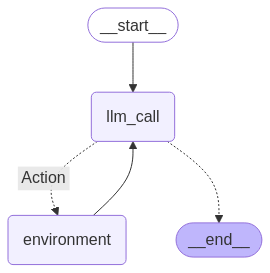

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_k7a8)
 Call ID: call_k7a8
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


In [6]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(
                [
                    SystemMessage(
                        content="You are a helpful assistant tasked with performing arithmetic on a set of inputs."
                    )
                ]
                + state["messages"]
            )
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END


# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages})
for m in messages["messages"]:
    m.pretty_print()